In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm'])


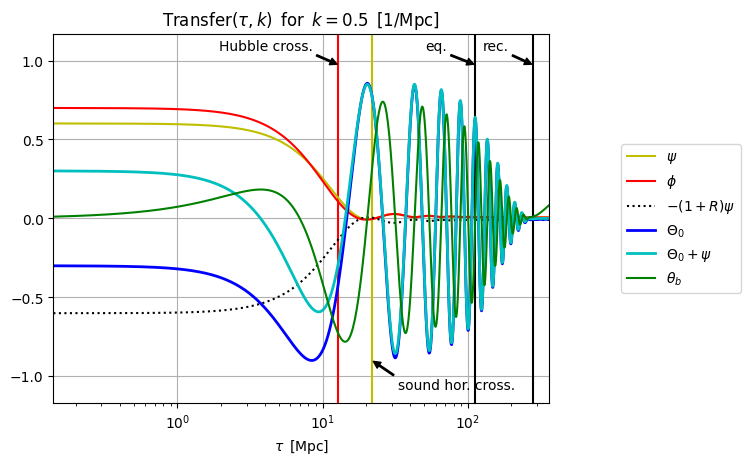

In [2]:
#############################################
#
# value of k that we want to follow in [1/Mpc]
#
k = 0.5  # 1/Mpc
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# we need to set the output field to something although
                   # the really releveant outpout here will be set with 'k_output_values'
                   'output':'mPk',
                   # value of k we want to polot in [1/Mpc]
                   'k_output_values':k,
                   # LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.2454,
                   # other options and settings
                   'compute damping scale':'yes', # needed to output the time of damping scale crossing
                   'gauge':'newtonian'}  
##############
#    
# call CLASS
#
M = Class()
M.set(common_settings)
M.compute()
#
# load perturbations
#
all_k = M.get_perturbations()  # this potentially constains scalars/tensors and all k values
print (all_k['scalar'][0].keys())
#    
one_k = all_k['scalar'][0]     # this contains only the scalar perturbations for the requested k values
#    
tau = one_k['tau [Mpc]']
Theta0 = 0.25*one_k['delta_g']
phi = one_k['phi']
psi = one_k['psi']
theta_b = one_k['theta_b']
a = one_k['a']
# compute related quantitites    
R = 3./4.*M.Omega_b()/M.Omega_g()*a    # R = 3/4 * (rho_b/rho_gamma)
zero_point = -(1.+R)*psi               # zero point of oscillations: -(1.+R)*psi
#
# get Theta0 oscillation amplitude (for vertical scale of plot)
#
Theta0_amp = max(Theta0.max(),-Theta0.min())
#
# get the time of decoupling
#
quantities = M.get_current_derived_parameters(['tau_rec'])
# print times.viewkeys()
tau_rec = quantities['tau_rec']
#
# use table of background quantitites to find the time of
# Hubble crossing (k / (aH)= 2 pi), sound horizon crossing (k * rs = 2pi)
#
background = M.get_background() # load background table
#print background.viewkeys()
#
background_tau = background['conf. time [Mpc]'] # read confromal times in background table
background_z = background['z'] # read redshift
background_k_over_aH = k/background['H [1/Mpc]']*(1.+background['z']) # read k/aH = k(1+z)/H
background_k_rs = k * background['comov.snd.hrz.'] # read k * rs
background_rho_m_over_r =\
    (background['(.)rho_b']+background['(.)rho_cdm'])\
    /(background['(.)rho_g']+background['(.)rho_ur']) # read rho_r / rho_m (to find time of equality)
#
# define interpolation functions; we want the value of tau when the argument is equal to 2pi (or 1 for equality)
#
tau_at_k_over_aH = interp1d(background_k_over_aH,background_tau)
tau_at_k_rs = interp1d(background_k_rs,background_tau)
tau_at_rho_m_over_r = interp1d(background_rho_m_over_r,background_tau)
#
# finally get these times
#
tau_Hubble = tau_at_k_over_aH(2.*math.pi)
tau_s = tau_at_k_rs(2.*math.pi)
tau_eq = tau_at_rho_m_over_r(1.)
#
#################
#
# start plotting
#
#################
#    
plt.xlim([tau[0],tau_rec*1.3])
plt.ylim([-1.3*Theta0_amp,1.3*Theta0_amp])
plt.xlabel(r'$\tau \,\,\, \mathrm{[Mpc]}$')
plt.title(r'$\mathrm{Transfer} (\tau,k) \,\,\, \mathrm{for} \,\,\, k=%g \,\,\, [1/\mathrm{Mpc}]$'%k)
plt.grid()
#
plt.axvline(x=tau_Hubble,color='r')
plt.axvline(x=tau_s,color='y')
plt.axvline(x=tau_eq,color='k')
plt.axvline(x=tau_rec,color='k')
#
plt.annotate(r'Hubble cross.',
                xy=(tau_Hubble,1.08*Theta0_amp),
                xytext=(0.15*tau_Hubble,1.18*Theta0_amp),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
plt.annotate(r'sound hor. cross.',
                 xy=(tau_s,-1.0*Theta0_amp),
                 xytext=(1.5*tau_s,-1.2*Theta0_amp),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
plt.annotate(r'eq.',
                 xy=(tau_eq,1.08*Theta0_amp),
                 xytext=(0.45*tau_eq,1.18*Theta0_amp),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
plt.annotate(r'rec.',
                 xy=(tau_rec,1.08*Theta0_amp),
                 xytext=(0.45*tau_rec,1.18*Theta0_amp),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
#
# Possibility to add functions one by one, saving between each (for slides)
#
plt.semilogx(tau,psi,'y-',label=r'$\psi$')
#plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#plt.savefig('one_k_1.pdf',bbox_inches='tight')
#
plt.semilogx(tau,phi,'r-',label=r'$\phi$')
#plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#plt.savefig('one_k_2.pdf',bbox_inches='tight')
#
plt.semilogx(tau,zero_point,'k:',label=r'$-(1+R)\psi$')
#plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#plt.savefig('one_k_3.pdf',bbox_inches='tight')
#
plt.semilogx(tau,Theta0,'b-',linewidth=2,label=r'$\Theta_0$')
#plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#plt.savefig('one_k_4.pdf',bbox_inches='tight')
#
plt.semilogx(tau,Theta0+psi,'c-',linewidth=2,label=r'$\Theta_0+\psi$')
#plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#plt.savefig('one_k_5.pdf',bbox_inches='tight')
#
plt.semilogx(tau,theta_b,'g-',label=r'$\theta_b$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.savefig('one_k.pdf',bbox_inches='tight')
#